## Import statements and loading the data

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import collections

2025-05-11 16:20:47.637134: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
f = h5py.File('bird_spectrograms.hdf5', 'r')
list(f.keys())

['amecro',
 'amerob',
 'bewwre',
 'bkcchi',
 'daejun',
 'houfin',
 'houspa',
 'norfli',
 'rewbla',
 'sonspa',
 'spotow',
 'whcspa']

In [3]:
for key in list(f.keys()):
    print(f[key].shape)

(128, 517, 66)
(128, 517, 172)
(128, 517, 144)
(128, 517, 45)
(128, 517, 125)
(128, 517, 84)
(128, 517, 630)
(128, 517, 37)
(128, 517, 187)
(128, 517, 263)
(128, 517, 137)
(128, 517, 91)


In [4]:
# set seeds to ensure reproducibility 
np.random.seed(5322)
tf.random.set_seed(5322)
random.seed(5322)

## Multiclass Classification (All species)

In [5]:
X_list = []
y_list = []

# loop through each species' data
for species in list(f.keys()):
    spectrograms = np.array(f[species])  # (128, 517, N)
    n_samples = spectrograms.shape[2]
    labels = [species] * n_samples

    X_list.append(spectrograms)
    y_list.extend(labels)

In [6]:
# stack and reshape
X = np.concatenate(X_list, axis = 2)      # (128, 517, total_samples)
X = np.transpose(X, (2, 0, 1))           # (samples, 128, 517)
X = X[..., np.newaxis]                   # (samples, 128, 517, 1)

In [7]:
# labels to arrays
y = np.array(y_list)

In [8]:
# encode species to ints
le = LabelEncoder()
y_encoded = le.fit_transform(y)          # e.g., 'amecro' → 0, 'amerob' → 1, etc.
label_map = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = len(le.classes_)
num_classes

12

In [9]:
# one hot encode
y_onehot = to_categorical(y_encoded)     # shape: (samples, 12)

In [10]:
# normalize per spectrogram to [0, 1]
X_min = np.min(X, axis = (1, 2, 3), keepdims = True)
X_max = np.max(X, axis = (1, 2, 3), keepdims = True)
X = (X - X_min) / (X_max - X_min + 1e-8)

In [11]:
# stratified split to get aligned train/test splits for both X, onehot labels, and raw integer labels
X_train, X_test, y_train, y_test, y_train_raw, y_test_raw = train_test_split(
    X, y_onehot, y_encoded, test_size = 0.2, random_state = 5322, stratify = y_encoded
)

In [12]:
# tried data augmentation by shifting and filling. rotating did not make sense so did not do that
datagen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = False,
    vertical_flip = False,
    fill_mode = 'nearest'
)

datagen.fit(X_train)

In [13]:
y_train_labels = np.argmax(y_train, axis = 1)

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train_labels),
    y = y_train_labels
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 2.490566037735849,
 1: 0.9635036496350365,
 2: 1.1478260869565218,
 3: 3.6666666666666665,
 4: 1.32,
 5: 1.9701492537313432,
 6: 0.2619047619047619,
 7: 4.4,
 8: 0.8859060402684564,
 9: 0.6285714285714286,
 10: 1.2,
 11: 1.8082191780821917}

In [14]:
# sanity check class distribution and weights
print("Training set class distribution:")
print(collections.Counter(y_train_labels))
print("\nComputed class weights:")
print(class_weights_dict)

# number of classes
print(f"\nNumber of classes: {num_classes}")

Training set class distribution:
Counter({6: 504, 9: 210, 8: 149, 1: 137, 2: 115, 10: 110, 4: 100, 11: 73, 5: 67, 0: 53, 3: 36, 7: 30})

Computed class weights:
{0: 2.490566037735849, 1: 0.9635036496350365, 2: 1.1478260869565218, 3: 3.6666666666666665, 4: 1.32, 5: 1.9701492537313432, 6: 0.2619047619047619, 7: 4.4, 8: 0.8859060402684564, 9: 0.6285714285714286, 10: 1.2, 11: 1.8082191780821917}

Number of classes: 12


In [15]:
# first multiclass model
model = Sequential([
    # layer group 1
    Conv2D(32, (3, 3), input_shape = (128, 517, 1), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    Dropout(0.2),
    MaxPooling2D(2, 2),
    # group 2
    Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    Dropout(0.3),
    MaxPooling2D(2, 2),
    # group 3
    Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    Dropout(0.3),
    MaxPooling2D(2, 2),
    # group 4
    Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    Dropout(0.4),
    MaxPooling2D(2, 2),
    # group 5
    Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    Dropout(0.4),
    MaxPooling2D(2, 2),
    # global pooling
    GlobalAveragePooling2D(),
    Dense(units = 128, activation = 'relu', kernel_regularizer = l2(0.0001)),
    Dropout(0.5),
    Dense(units = num_classes, activation = 'softmax')
], name = "Multiclass_Model_1")

model.compile(
    optimizer = Adam(learning_rate = 0.0005),
    loss = CategoricalCrossentropy(label_smoothing = 0.05),
    metrics = ['accuracy']
)

model.summary()

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size = 64),
    validation_data = (X_test, y_test),
    epochs = 100,
    callbacks = [early_stopping],
    class_weight = class_weights_dict
)

# result
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')

Model: "Multiclass_Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 517, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 128, 517, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128, 517, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 258, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 258, 64)       18496     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 258, 64)

In [16]:
# predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# get class labels in correct order (by integer encoding)
target_names = [label_map[i] for i in sorted(label_map.keys())]

print(classification_report(y_true, y_pred, target_names = target_names, digits = 4, zero_division = 0))

13/13 [==============================] - 8s 577ms/step
              precision    recall  f1-score   support

      amecro     0.0000    0.0000    0.0000        13
      amerob     0.0000    0.0000    0.0000        35
      bewwre     0.0435    0.1379    0.0661        29
      bkcchi     0.0000    0.0000    0.0000         9
      daejun     0.0000    0.0000    0.0000        25
      houfin     0.0000    0.0000    0.0000        17
      houspa     0.3016    0.7302    0.4269       126
      norfli     0.0000    0.0000    0.0000         7
      rewbla     0.0000    0.0000    0.0000        38
      sonspa     0.0000    0.0000    0.0000        53
      spotow     0.0000    0.0000    0.0000        27
      whcspa     0.0000    0.0000    0.0000        18

    accuracy                         0.2418       397
   macro avg     0.0288    0.0723    0.0411       397
weighted avg     0.0989    0.2418    0.1403       397



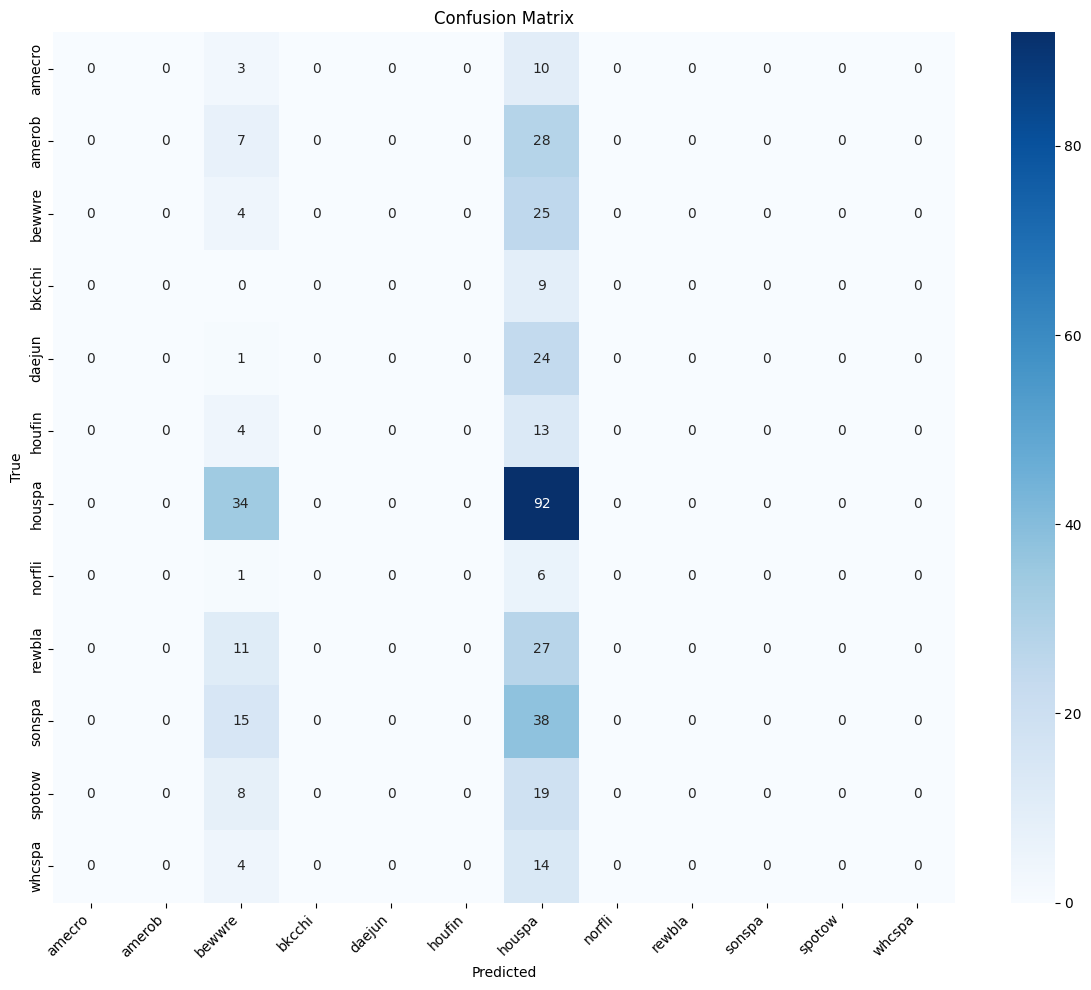

In [17]:
# confusion matrix
species_names = list(f.keys())
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = species_names, yticklabels = species_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

This model performs terribly, but technically did better than random guessing (24% > 8.3% or 1/12) so I guess the model learned "something"\
Accuracy is low, AUC is low, the classification report shows pretty much house sparrow being the dominant class in our model\
I already made augmentations and tried to balance the class imbalance. I do not know if I need to resample for this assignment\
Model stopped very early on as well

## Multiclass Classification with adjustments
- Made the model a bit simpler with less layers
- Started at 64 instead of 32 filters
- Reduced dropout rates to 0.1 to allow more learning
- Use global max pooling 2d instead of global average pooling 2d since max pooling usually works better than average pooling
- Also reduced batch size to 32 from 64
- Previous model was slow to converge so increased learning rate to 0.001 from 0.0005
- Reduced label smoothing to 0.03
- Added reduce lr on plateau to allow the model to get out of potential "traps" and because the previous model did not seem to learn efficiently

In [18]:
# second multiclass model
model = Sequential([
    # layer group 1
    Conv2D(64, (3, 3), input_shape = (128, 517, 1), activation = 'relu', kernel_regularizer = l2(0.00001), padding = 'same'),
    BatchNormalization(),
    Dropout(0.1),
    MaxPooling2D(2, 2),
    # group 2
    Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.00001), padding = 'same'),
    BatchNormalization(),
    Dropout(0.1),
    MaxPooling2D(2, 2),
    # group 3
    Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.00001), padding = 'same'),
    BatchNormalization(),
    Dropout(0.1),
    MaxPooling2D(2, 2),
    # group 4
    Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer = l2(0.00001), padding = 'same'),
    BatchNormalization(),
    Dropout(0.1),
    MaxPooling2D(2, 2),
    # global pooling
    GlobalMaxPooling2D(),
    Dense(units = 128, activation = 'relu', kernel_regularizer = l2(0.00001)),
    Dropout(0.1),
    Dense(units = num_classes, activation = 'softmax')
], name = "Multiclass_Model_2")

model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = CategoricalCrossentropy(label_smoothing = 0.03),
    metrics = ['accuracy']
)

model.summary()

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-5, verbose = 1)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size = 32),
    validation_data = (X_test, y_test),
    epochs = 100,
    callbacks = [early_stopping, reduce_lr],
    class_weight = class_weights_dict
)

# result
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')

Model: "Multiclass_Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 517, 64)      640       
                                                                 
 batch_normalization_5 (Bat  (None, 128, 517, 64)      256       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 128, 517, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 258, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 258, 64)       36928     
                                                                 
 batch_normalization_6 (Bat  (None, 64, 258, 64)

In [19]:
# predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# get class labels in correct order (by integer encoding)
target_names = [label_map[i] for i in sorted(label_map.keys())]

print(classification_report(y_true, y_pred, target_names = target_names, digits = 4, zero_division = 0))

13/13 [==============================] - 11s 844ms/step
              precision    recall  f1-score   support

      amecro     0.0000    0.0000    0.0000        13
      amerob     0.0000    0.0000    0.0000        35
      bewwre     0.0000    0.0000    0.0000        29
      bkcchi     0.0323    0.1111    0.0500         9
      daejun     0.0000    0.0000    0.0000        25
      houfin     0.0000    0.0000    0.0000        17
      houspa     0.0000    0.0000    0.0000       126
      norfli     0.0193    0.5714    0.0374         7
      rewbla     0.0000    0.0000    0.0000        38
      sonspa     0.0000    0.0000    0.0000        53
      spotow     0.0577    0.3333    0.0984        27
      whcspa     0.0000    0.0000    0.0000        18

    accuracy                         0.0353       397
   macro avg     0.0091    0.0847    0.0155       397
weighted avg     0.0050    0.0353    0.0085       397



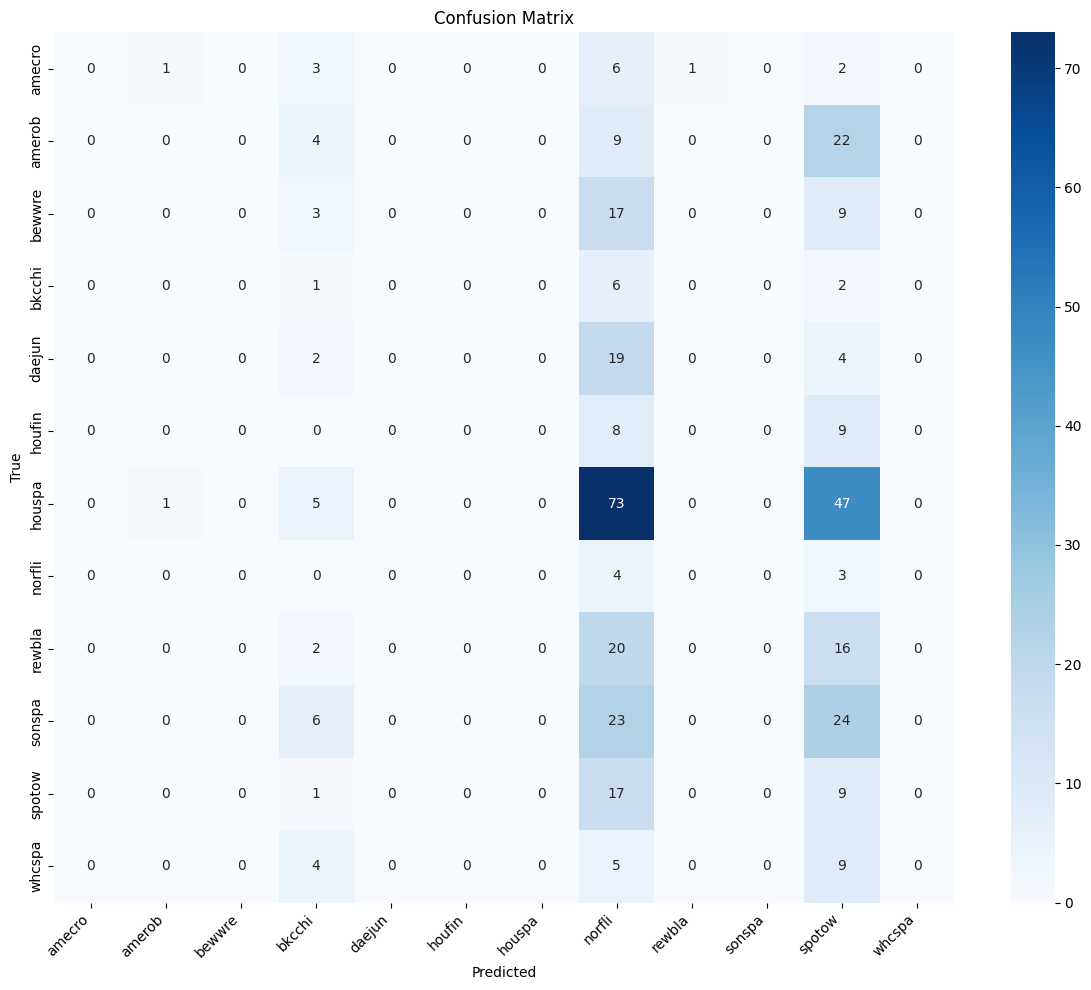

In [20]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = species_names, yticklabels = species_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

Still low training and validation accuracy indicates underfitting\
Models does worse than random guessing so need to increase learning rate for earlier epochs, maybe even less dropout early on as well\
Might need to increase filter sizes early on too\
Increase batch size to speed up model a little. smaller batch size does not seem to help with multiclass

## Another Multiclass Model with more Adjustments
- Removed a layer since our dataset is only a couple thousand samples so the complexity might have led to the overfitting in previous model
- Increased the dropout a little bit to 0.3 from 0.1
- Increased the starting learning rate to 0.005 from 0.001 to hopeful let the model learn a little more early on
- Decreased the l2 to 0.0001 from 0.00001 to give it a stronger penalty a reduce overfitting slightly

In [23]:
# third multiclass model
model = Sequential([
    # layer group 1
    Conv2D(64, (3, 3), input_shape = (128, 517, 1), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    Dropout(0.3),
    MaxPooling2D(2, 2),
    # group 2
    Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    Dropout(0.3),
    MaxPooling2D(2, 2),
    # group 3
    Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    Dropout(0.3),
    MaxPooling2D(2, 2),
    # global pooling
    GlobalMaxPooling2D(),
    Dense(units = 128, activation = 'relu', kernel_regularizer = l2(0.0001)),
    Dropout(0.4),
    Dense(units = num_classes, activation = 'softmax')
], name = "Multiclass_Model_3")

model.compile(
    optimizer = Adam(learning_rate = 0.005),
    loss = CategoricalCrossentropy(label_smoothing = 0.05),
    metrics = ['accuracy']
)

model.summary()

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-5, verbose = 1)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size = 64),
    validation_data = (X_test, y_test),
    epochs = 100,
    callbacks = [early_stopping, reduce_lr],
    class_weight = class_weights_dict
)

# result
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')

Model: "Multiclass_Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 517, 64)      640       
                                                                 
 batch_normalization_18 (Ba  (None, 128, 517, 64)      256       
 tchNormalization)                                               
                                                                 
 dropout_24 (Dropout)        (None, 128, 517, 64)      0         
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 64, 258, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 258, 128)      73856     
                                                                 
 batch_normalization_19 (Ba  (None, 64, 258, 128

In [24]:
# predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# get class labels in correct order (by integer encoding)
target_names = [label_map[i] for i in sorted(label_map.keys())]

print(classification_report(y_true, y_pred, target_names = target_names, digits = 4, zero_division = 0))

13/13 [==============================] - 14s 1s/step
              precision    recall  f1-score   support

      amecro     0.0000    0.0000    0.0000        13
      amerob     0.0000    0.0000    0.0000        35
      bewwre     0.0000    0.0000    0.0000        29
      bkcchi     0.0270    0.2222    0.0482         9
      daejun     0.0000    0.0000    0.0000        25
      houfin     0.0000    0.0000    0.0000        17
      houspa     0.3427    0.7778    0.4757       126
      norfli     0.0000    0.0000    0.0000         7
      rewbla     0.0541    0.0526    0.0533        38
      sonspa     0.0000    0.0000    0.0000        53
      spotow     0.0000    0.0000    0.0000        27
      whcspa     0.0000    0.0000    0.0000        18

    accuracy                         0.2569       397
   macro avg     0.0353    0.0877    0.0481       397
weighted avg     0.1145    0.2569    0.1572       397



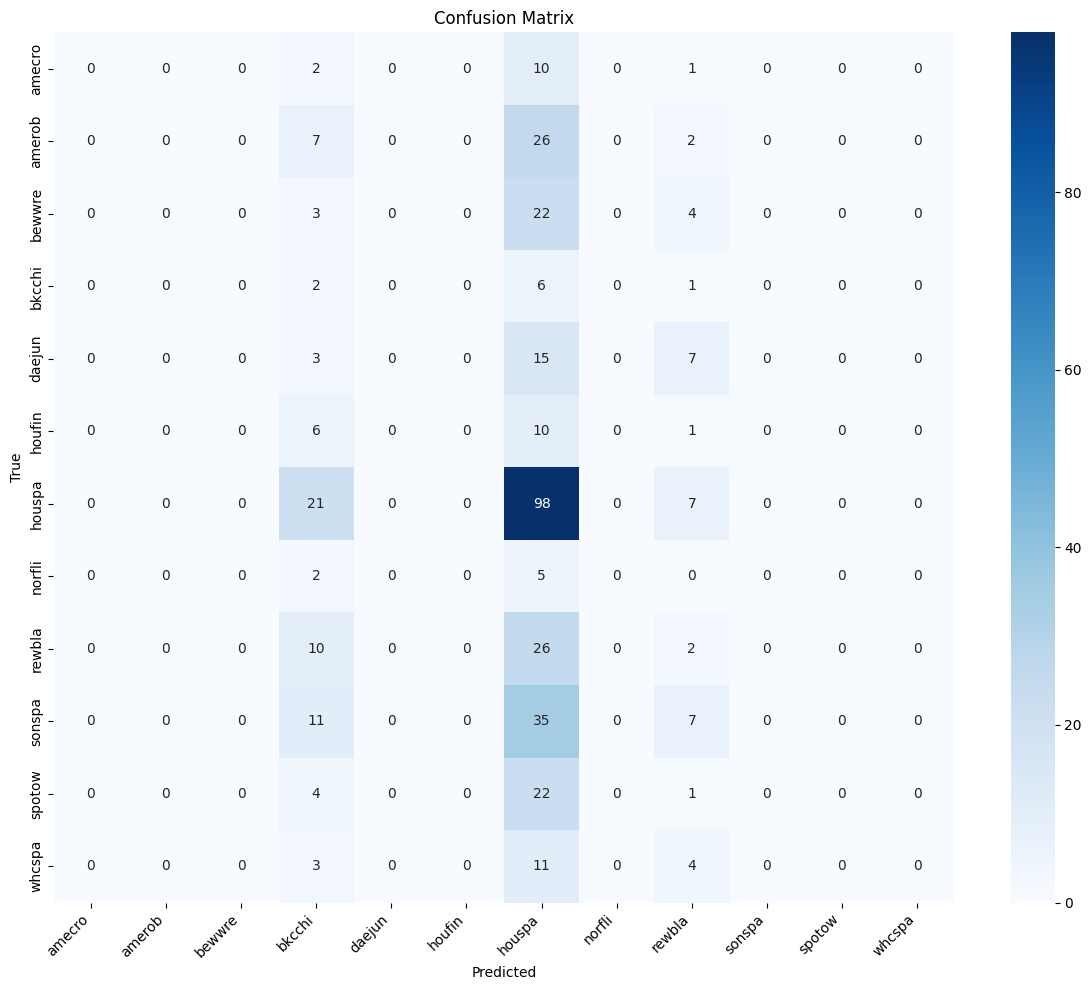

In [25]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = species_names, yticklabels = species_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

It seems all of my models do not do well in predicting all classes due to class imbalance even though I tried to handle it a bit\
Third model did technically do the best in terms of both accuracy and precision/recall for the house sparrow class (majority class)

## Prediction on the 3 sample audios

## Generate the spectrograms from the 3 test audio files

In [41]:
import soundfile as sf
import os
from scipy.signal import spectrogram
from tensorflow.keras.preprocessing import image

In [38]:
audio_folder = 'test/'
output_folder = 'test_spectrograms/'
os.makedirs(output_folder, exist_ok = True)

for filename in os.listdir(audio_folder):
    if filename.endswith('.mp3'):
        file_path = os.path.join(audio_folder, filename)
        print(f"Processing {filename}")

        # load audio file
        y, sr = sf.read(file_path)

        # convert stereo to mono if needed
        if len(y.shape) > 1:
            y = y.mean(axis = 1)

        # compute spectrogram
        f, t, Sxx = spectrogram(y, sr, nperseg = 1024, noverlap = 512)

        # convert to dB scale
        Sxx_dB = 10 * np.log10(Sxx + 1e-10)

        # plot and save just to see spectrogram
        plt.figure(figsize = (10, 4))
        plt.pcolormesh(t, f, Sxx_dB, shading = 'gouraud')
        plt.colorbar(format = '%+2.0f dB')
        plt.title(f'Spectrogram for {filename}')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.tight_layout()

        output_file = os.path.join(output_folder, filename.replace('.mp3', '.png'))
        plt.savefig(output_file)
        plt.close()

print("Done generating spectrograms.")

Processing test3.mp3
Processing test2.mp3
Processing test1.mp3
Done generating spectrograms.


## Make the predictions using the third model which was the best we could do

In [49]:
spectrogram_folder = 'test_spectrograms/'
spectrogram_files = [f for f in os.listdir(spectrogram_folder) if f.endswith('.png')]

for filename in spectrogram_files:
    file_path = os.path.join(spectrogram_folder, filename)
    
    # Load the image
    spectrogram = plt.imread(file_path).astype('float32')

    # Handle RGBA images (drop alpha channel)
    if spectrogram.shape[-1] == 4:
        print(f"Warning: {filename} has 4 channels (RGBA), dropping alpha.")
        spectrogram = spectrogram[:, :, :3]

    # Convert RGB to grayscale
    if spectrogram.ndim == 3 and spectrogram.shape[2] == 3:
        spectrogram = 0.2989 * spectrogram[:, :, 0] + \
                      0.5870 * spectrogram[:, :, 1] + \
                      0.1140 * spectrogram[:, :, 2]

    # Expand dims to make it (H, W, 1)
    spectrogram = np.expand_dims(spectrogram, axis=-1)

    # Now resize with proper shape
    spectrogram_resized = image.smart_resize(spectrogram, (128, 517))

    # Normalize
    spectrogram_resized = spectrogram_resized / 255.0

    # Add batch dimension for prediction: (1, H, W, C)
    spectrogram_resized = np.expand_dims(spectrogram_resized, axis=0)

    print(f"{filename} input shape: {spectrogram_resized.shape}")

    # Predict
    predictions = model.predict(spectrogram_resized)

    # Top 3 predictions
    top_3_idx = np.argsort(predictions[0])[::-1][:3]
    top_3_probs = predictions[0][top_3_idx]

    print(f"\nPredictions for {filename}:")
    for i, (idx, prob) in enumerate(zip(top_3_idx, top_3_probs)):
        print(f"Top {i+1} Prediction: Class {species_names[idx]}, Probability: {prob:.4f}")


test1.png input shape: (1, 128, 517, 1)
1/1 [==============================] - 0s 90ms/step

Predictions for test1.png:
Top 1 Prediction: Class houspa, Probability: 0.2071
Top 2 Prediction: Class bkcchi, Probability: 0.1657
Top 3 Prediction: Class rewbla, Probability: 0.1278
test3.png input shape: (1, 128, 517, 1)
1/1 [==============================] - 0s 88ms/step

Predictions for test3.png:
Top 1 Prediction: Class houspa, Probability: 0.2071
Top 2 Prediction: Class bkcchi, Probability: 0.1658
Top 3 Prediction: Class rewbla, Probability: 0.1279
test2.png input shape: (1, 128, 517, 1)
1/1 [==============================] - 0s 88ms/step

Predictions for test2.png:
Top 1 Prediction: Class houspa, Probability: 0.2071
Top 2 Prediction: Class bkcchi, Probability: 0.1657
Top 3 Prediction: Class rewbla, Probability: 0.1278


Not too surprising\
Our model only predicted/trained well (if trained at all) on 3 species, so the predictions were pretty much going to be the 3 species we had\
Since there was data imbalance, it is logical the model would predict the majority class most often which is what we see with house sparrow\
It does seem at least, that the model was able to notice that the audio spectrograms of the three files were different given the 3 very slightly different probabilities in the predictions, however, given out lacking model, they were pretty similar in their predictions\
Given the computation constraints of using a 2019 macbook and our imbalanced dataset plus the time constraints of even running each model, we did the best we could :)